# Notebook for creating sample data to use when working on the boundary crossing gridding method.

### Note:
- we will need to figure out what to do about edge cases, like when the drifter does not move out of a cell during a timestep, if a single drifter crosses two cell boundaries during a single timestep (ex: passes though a corner, spotty drifter data), etc.

In [1]:
from datetime import datetime
import os
import math
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely.geometry import Point, Polygon, LineString, MultiPoint

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width',1000)

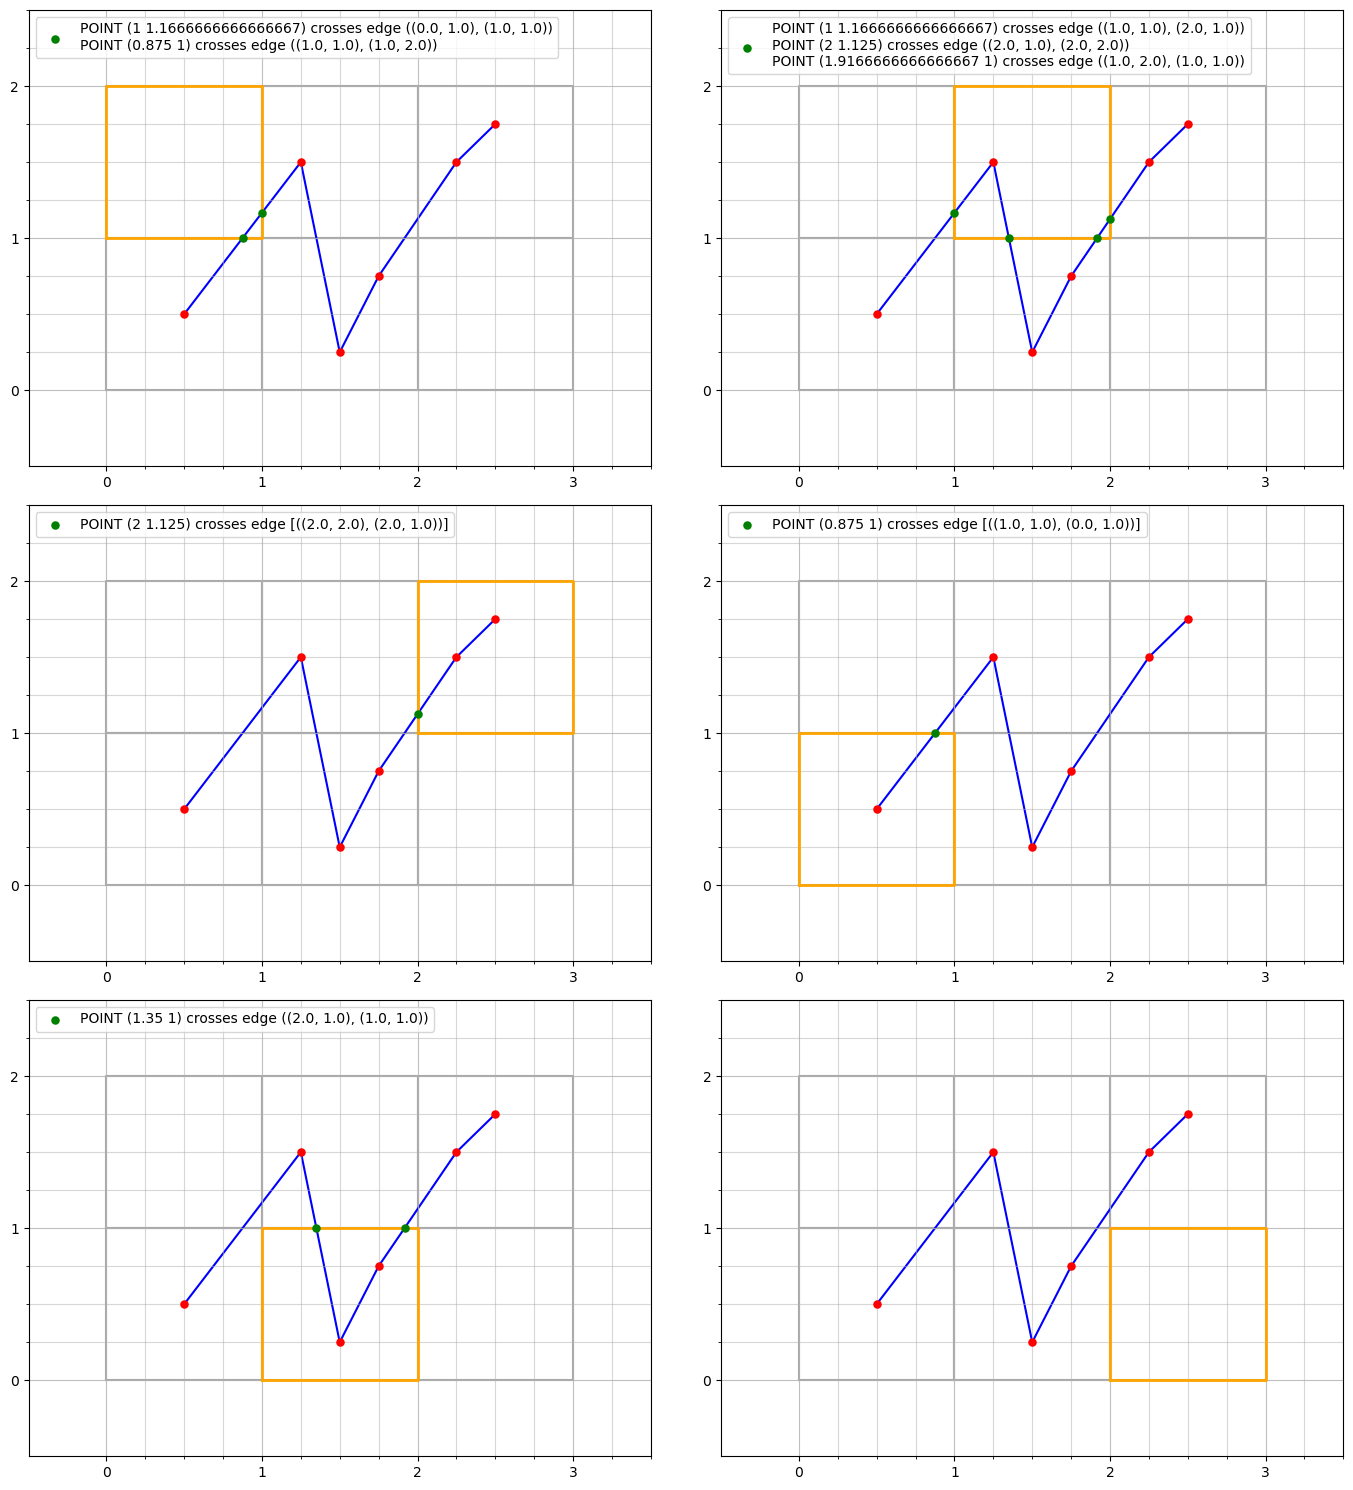

In [2]:
def pairwise(iterable):
    from itertools import tee
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def add_gridlines(ax):
    major_ticks = np.arange(0, 4, 1)
    minor_ticks = np.arange(0, 4, 0.25)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=0.8)


def gen_color(cmap, n, reverse=False):
    '''see: https://github.com/binodbhttr/mycolorpy/blob/master/usage_example.ipynb'''
    c_map = matplotlib.colormaps[cmap] # select the desired cmap
    arr=np.linspace(0,1,n) #create a list with numbers from 0 to 1 with n items
    colorlist=list()
    for c in arr:
        rgba=c_map(c) #select the rgba value of the cmap at point c which is a number between 0 to 1
        clr=colors.rgb2hex(rgba) #convert to hex
        colorlist.append(str(clr)) # create a list of these colors
    if reverse==True:
        colorlist.reverse()
    return colorlist


def find_crossings(x, y, poly):
    polyLS = LineString(list(poly.exterior.coords))  # the polygon as a LineString
    segments = LineString(zip(x, y))
    
    crossing_pts = polyLS.intersection(lin)  # intersection point
    points = list(polyLS.coords)
    crossed_edges = []
    for i,j in zip(points, points[1:]):
       if LineString((i, j)).distance(crossing_pts) < 1e-8:
           crossed_edges.append((i, j))

    #print('\n\npolyLS = ', polyLS)
    #print('\n\nsegments = ', segments)
    #print('\n\ncrossing_pts = ', crossing_pts)
    #print('\n\npoints = ', points)
    #print('\n\ncrossed_edges = ', crossed_edges)


def plot_crossing_points(ax, lin, x, y, pol, ind):
    polin = LineString(list(pol.exterior.coords))  # the polygon as a LineString
    pt = polin.intersection(lin)  # intersection point
       
    # iterate through the edges to determine if Shapely point is within. Here, 'points' is the list of tuples that make
    # up the polygon boundary. I'll eventually need to check whether the output is a Point or MultiPoint before using it
    # for future calculations (i.e., isinstance(pt, shapely.geometry.Point) or isinstance(pt, shapely.geometry.MultiPoint))
    points = list(polin.coords)
    crossed_edges = []
    for i,j in zip(points, points[1:]):
       if LineString((i,j)).distance(pt) < 1e-8:
           crossed_edges.append((i,j))

    if len(crossed_edges) == 0:
        legstr = 'No boundary crossings for this cell'
    else:
        if isinstance(pt, shapely.geometry.MultiPoint):
            strlist = []
            for intercept_point, edge in zip(pt.geoms, crossed_edges):
                strlist.append(str(intercept_point) + ' crosses edge ' + str(edge))
            legstr = '\n'.join(strlist)
        else:  # isinstance(pt, shapely.geometry.Point)
            legstr = str(pt) + ' crosses edge ' + str(crossed_edges)

    add_gridlines(ax)
    
    # plot all the cells in the polygon list
    for cell in polylist:
        ax.plot(list(zip(*cell))[0], list(zip(*cell))[1], 'darkgray', zorder=0, label='_no_label_')
    
    # plot the line and the cell boundary
    ax.plot(*lin.xy, 'b', zorder=1, label='_no_label_')
    ax.plot(*pol.exterior.xy, 'orange', zorder=2, label='_no_label_', linewidth=2)
    
    # plot the crossing locations
    if len(crossed_edges) > 0:
        if isinstance(pt, shapely.geometry.MultiPoint):
            intx = [intpt.x for intpt in pt.geoms]
            inty = [intpt.y for intpt in pt.geoms]
        elif isinstance(pt, shapely.geometry.Point):
            intx = [pt.x]
            inty = [pt.y]
        else:
            print('Error! pt should either be a Point or a MultiPoint')
        ax.scatter(intx, inty, c='green', s=150, marker='.', linewidth=0, zorder=3, label=legstr, edgecolors='magenta')
        ax.legend(loc='upper left')
    
    # plot the end points of the original line (this would be the drifter records)
    ax.scatter(x, y, c='red', s=150, marker='.', linewidth=0, zorder=3, label='_no_label_', edgecolors='magenta')
    
    ax.set_xlim([-0.5, 3.5])
    ax.set_ylim([-0.5, 2.5])


#####################################################################################
# find the intersection points and add them to a figure
#####################################################################################
tpts = [(0.5, 0.5, ), (1.25, 1.5), (1.5, 0.25), (1.75, 0.75), (2.25, 1.5), (2.5, 1.75)]
x = [p[0] for p in tpts]
y = [p[1] for p in tpts]
sample_times = pd.date_range("2018-01-01", "2018-01-02", periods=len(tpts))  # freq='H' instead of periods returns hourly data 
t = [st for st in sample_times]

polylist = [[(0, 1), (1, 1), (1, 2), (0, 2), (0, 1)], [(1, 1), (2, 1), (2, 2), (1, 2), (1, 1)], [(2, 1), (3, 1), (3, 2), (2, 2), (2, 1)], 
            [(0, 0), (1, 0), (1, 1), (0, 1), (0, 0)], [(1, 0), (2, 0), (2, 1), (1, 1), (1, 0)], [(2, 0), (3, 0), (3, 1), (2, 1), (2, 0)]]
poly = [Polygon(cell) for cell in polylist]

fig = plt.figure(figsize=(14, 15))
lin = LineString(zip(x, y))
for ind, pol in enumerate(poly):
    ax = fig.add_subplot(3, 2, ind+1)
    plot_crossing_points(ax, lin, x, y, pol, ind)

plt.tight_layout()
plotdir = '/store/projects/gridded_drifter_comparisons/output/plots/gridding_methods/boundary_crossings/'
plt.savefig(os.path.join(plotdir, 'sample_boundary_crossings.png'))
plt.show()


In [3]:
def determine_unique_polygon_edges(polylist):
        polyedges = []
        for pl in polylist:
            for seg_ind in range(0, len(pl)-1):
                cell_edge = (pl[seg_ind], pl[seg_ind+1])
                cell_edge_rev = (cell_edge[1], cell_edge[0])
                if (cell_edge not in polyedges) and (cell_edge_rev not in polyedges):
                    polyedges.append(cell_edge)
        pedges = [LineString(edge) for edge in polyedges]
        return pedges


def create_cell_list(num_horz=5, num_vert=5, show_plot=False):
    cell_list = []
    for i in range(0, num_horz):
        for j in range(0, num_vert):
            cell_list.append([(i, j), (i+1, j), (i+1, j+1), (i, j+1), (i, j)])

    if show_plot:    
        for cind, clist in enumerate(cell_list):
            x = [p[0] for p in clist]
            y = [p[1] for p in clist]
            plt.plot(x, y)
            plt.annotate(str(cind), (np.mean(x), np.mean(y)))

    return cell_list

def build_cell_definition(cell_list):
    cell_defs = {}
    for cind, clist in enumerate(cell_list):
        line_segs = [LineString(p) for p in pairwise(clist)]
        cellLS = [p for p in pairwise(clist)]
        complete_list = []
        for c in cellLS:
            complete_list.extend([LineString([c[0], c[1]]), LineString([c[1], c[0]])])
        cell_defs[cind] = complete_list
    return cell_defs


def determine_incells(lstring, cell_defs):
    incell_list = []
    for c in cell_defs.keys():
        incell = False
        if lstring in cell_defs[c]:
            incell = True
            incell_list.append(c)
    x, y = lstring.coords.xy
    #print(list(zip(x, y)), ' is in cells ', incell_list)
    return incell_list


def old_find_crossings_per_cell(x, y, t, polylist, cell_defs):
    """
    x and y: lists of x and y positions
    t: list of associated times for each point
    polylist: list of lists of coordinates defining multiple polygon areas.
    cell_defs: dictionary with an index assigned to each grid cell for keys and 
               a list of edge LineStrings for values.
    """

    # pass in x, y, t and a list of unique boundary edges
    # create a list of track segments
    # step through each track segment
    # check which, if any, cell edge is crossed (will save time over going though each cell because some cell edges are duplicated that way)
    # find the location and times of each boundary crossing point as well as the edge that is crossed

    # calculate the unique boundary edges
    pedges = determine_unique_polygon_edges(polylist)
    
    xc = []
    yc = []
    tc = []
    edges_list = []
    incells_list = []
    #segments = [LineString(p) for p in pairwise(zip(x, y))]
    for i in range(0, len(x)-1):
        segment = [(x[i], y[i]), (x[i+1], y[i+1])]
        txtstr = ('\nfor track segment ' + str(segment) 
                  + '\nstart_time, end_time = ' + str(t[i].strftime('%Y-%m-%d %X')) + ', ' + str(t[i+1].strftime('%Y-%m-%d %X')) 
                  + '\n------------------------------------------------------------------')
        times = [t[i], t[i+1]]
        segLS = LineString(segment)  
        seg_dist = math.dist(list(segment[0]), list(segment[1]))
        tdiff = (t[i+1] - t[i]).total_seconds()  # /60/60

        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(x, y, 'silver', linestyle='--', zorder=1, label='full track')
        ax.plot(x, y, 'o', color='silver', zorder=4, label='_no_label_', markeredgecolor='k')
        ax.plot(*segLS.xy, 'b', label='segment', linewidth=2, zorder=3)

        add_legstr = True
        for pedge in pedges:
            ax.plot(*pedge.xy, 'gray', zorder=0)
            crossing = pedge.intersection(segLS)
            if crossing:
                if isinstance(crossing, shapely.geometry.LineString):
                    mid_point = crossing.interpolate(0.5, normalized = True)
                    crossing = mid_point
                    #continue
                #txtstr = (txtstr + '\n\nfor edge ' + str([(xy[0], xy[1]) for xy in pedge.xy]) + ':')
                # calculate distance from start point to the crossing point and determine what portion of the track this
                # represents. Use this fraction to get the amount of time that has elapsed and thus the time at the crossing point
                dist = math.dist(list(segment[0]), [crossing.x, crossing.y])
                crossing_time = pd.to_datetime(t[i]) + pd.to_timedelta(tdiff * dist/seg_dist, unit='s')
                #txtstr = (txtstr + '\ncrossing (x, y, t) = (' + str(crossing.x) + ', ' + str(crossing.y) + ', ' + str(crossing_time) + ')')
                txtstr = (txtstr + '\ncrossing (x, y, t, edge, in_cells) = (' + str(round(crossing.x, 2)) + ', ' 
                          + str(round(crossing.y,2)) + ', ' + str(crossing_time.strftime('%Y-%m-%d %X')) + ', ' 
                          + str([(xy[0], xy[1]) for xy in pedge.xy]) + ', ' + str(determine_incells(pedge, cell_defs)) +  ')')
                xc.append(crossing.x)
                yc.append(crossing.y)
                tc.append(crossing_time)  # .strftime('%Y-%m-%d %X')
                edges_list.append([(xy[0], xy[1]) for xy in pedge.xy])
                incells_list.append(determine_incells(pedge, cell_defs))

                cbstr = '_no_label_'
                dotstr = '_no_label_'
                if add_legstr:
                    cbstr = 'crossed edge(s)'
                    dotstr = 'crossing point(s)'
                ax.plot(*pedge.xy, 'r', label=cbstr, zorder=2)
                ax.plot(crossing.x, crossing.y, 'o', markersize=7, markerfacecolor='yellow', markeredgecolor='green', label=dotstr, zorder=4)
                add_legstr = False

        plt.legend(loc='upper left', fontsize=10)
        plt.title(txtstr + '\n')
        plt.show()
    
    for c in list(zip(xc, yc, tc, edges_list, incells_list)):
        print(c)
        
    return xc, yc, tc, edges_list, incells_list


def find_crossings_per_cell(x, y, t, polylist, cell_defs):
    """
    x and y: lists of x and y positions
    t: list of associated times for each point
    polylist: list of lists of coordinates defining multiple polygon areas.
    cell_defs: dictionary with an index assigned to each grid cell for keys and 
               a list of edge LineStrings for values.
    """

    # pass in x, y, t and a list of unique boundary edges
    # create a list of track segments
    # step through each track segment
    # check which, if any, cell edge is crossed (will save time over going though each cell because some cell edges are duplicated that way)
    # find the location and times of each boundary crossing point as well as the edge that is crossed

    # calculate the unique boundary edges
    pedges = determine_unique_polygon_edges(polylist)
    
    rowlist = []
    for i in range(0, len(x)-1):
        segment = [(x[i], y[i]), (x[i+1], y[i+1])]
        txtstr = ('\nfor track segment ' + str(segment) 
                  + '\nstart_time, end_time = ' + str(t[i].strftime('%Y-%m-%d %X')) + ', ' + str(t[i+1].strftime('%Y-%m-%d %X')) 
                  + '\n------------------------------------------------------------------')
        times = [t[i], t[i+1]]
        segLS = LineString(segment)  
        seg_dist = math.dist(list(segment[0]), list(segment[1]))
        tdiff = (t[i+1] - t[i]).total_seconds()  # /60/60

        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(x, y, 'silver', linestyle='--', zorder=1, label='full track')
        ax.plot(x, y, 'o', color='silver', zorder=4, label='_no_label_', markeredgecolor='k')
        ax.plot(*segLS.xy, 'b', label='segment', linewidth=2, zorder=3)

        add_legstr = True
        for pedge in pedges:
            ax.plot(*pedge.xy, 'gray', zorder=0)
            crossing = pedge.intersection(segLS)
            if crossing:
                if isinstance(crossing, shapely.geometry.LineString):
                    # Change this to take the last point in the linestring instead of the mid-point! ##################################################
                    mid_point = crossing.interpolate(0.5, normalized = True)
                    crossing = mid_point
                # calculate distance from start point to the crossing point and determine what portion of the track this
                # represents. Use this fraction to get the amount of time that has elapsed and thus the time at the crossing point
                dist = math.dist(list(segment[0]), [crossing.x, crossing.y])
                crossing_time = pd.to_datetime(t[i]) + pd.to_timedelta(tdiff * dist/seg_dist, unit='s')
                txtstr = (txtstr + '\ncrossing (x, y, t, edge, in_cells) = (' + str(round(crossing.x, 2)) + ', ' 
                          + str(round(crossing.y,2)) + ', ' + str(crossing_time.strftime('%Y-%m-%d %X')) + ', ' 
                          + str([(xy[0], xy[1]) for xy in pedge.xy]) + ', ' + str(determine_incells(pedge, cell_defs)) +  ')')
                searchstr = '_'.join([str(crossing.x), str(crossing.y), str(crossing_time)]).replace(' ', '_')

                row = {
                    'xc': crossing.x, 'yc': crossing.y, 'tc': crossing_time, 
                    'edges': [(xy[0], xy[1]) for xy in pedge.xy], 
                    'incells': determine_incells(pedge, cell_defs),
                    'searchstrs': searchstr
                }
                rowlist.append(row)

                cbstr = '_no_label_'
                dotstr = '_no_label_'
                if add_legstr:
                    cbstr = 'crossed edge(s)'
                    dotstr = 'crossing point(s)'
                ax.plot(*pedge.xy, 'r', label=cbstr, zorder=2)
                ax.plot(crossing.x, crossing.y, 'o', markersize=7, markerfacecolor='yellow', markeredgecolor='green', label=dotstr, zorder=4)
                add_legstr = False

        plt.legend(loc='upper left', fontsize=10)
        plt.title(txtstr + '\n')
        plt.show()

    aggdf = pd.DataFrame(rowlist)
    return aggdf



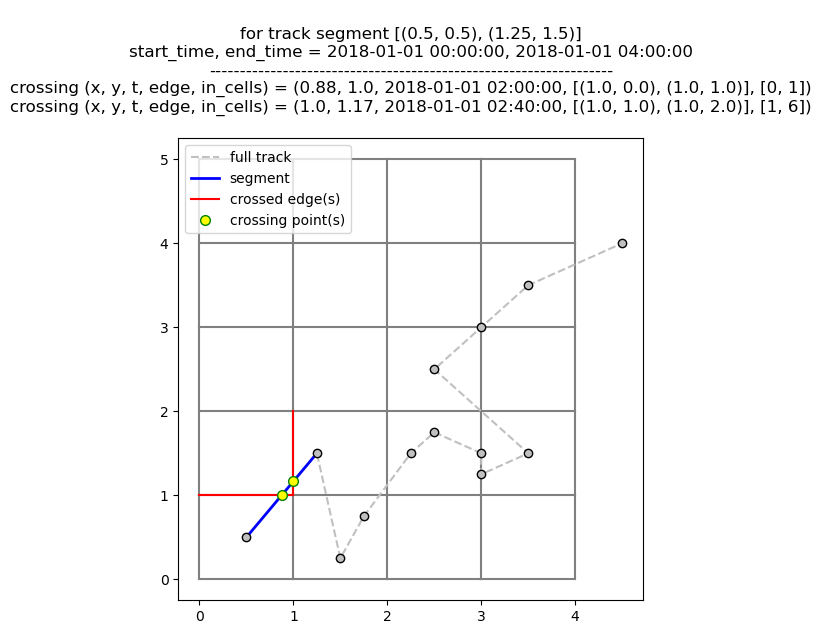

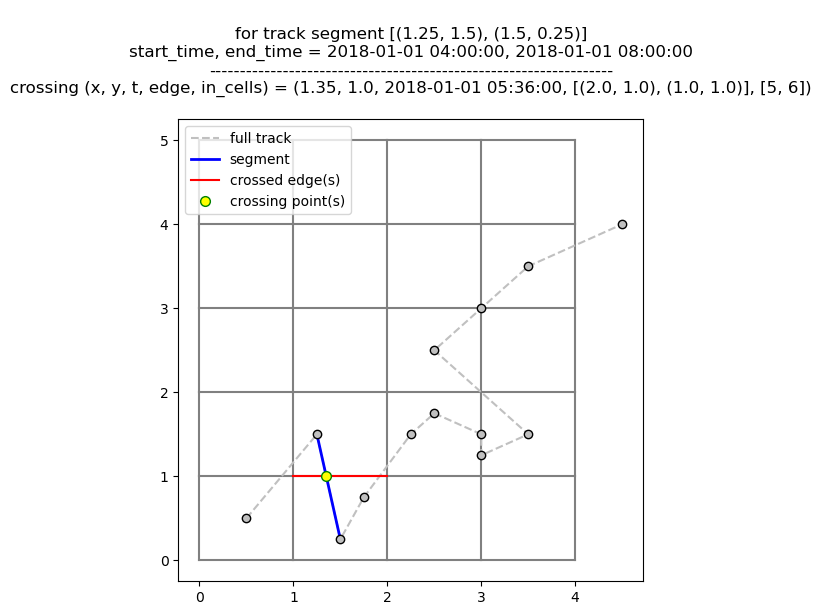

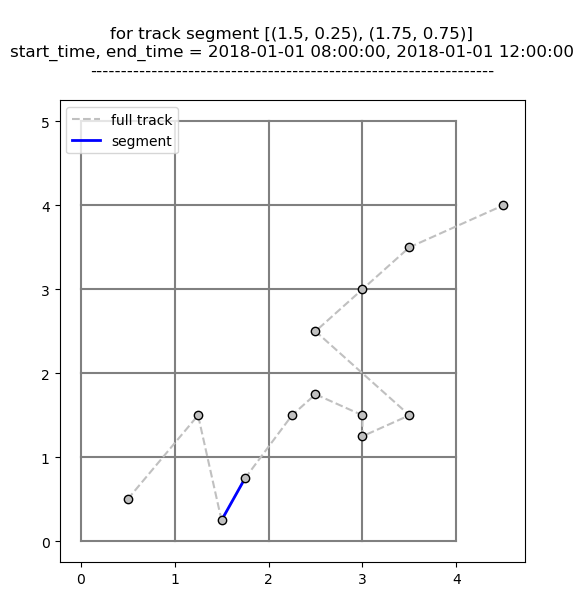

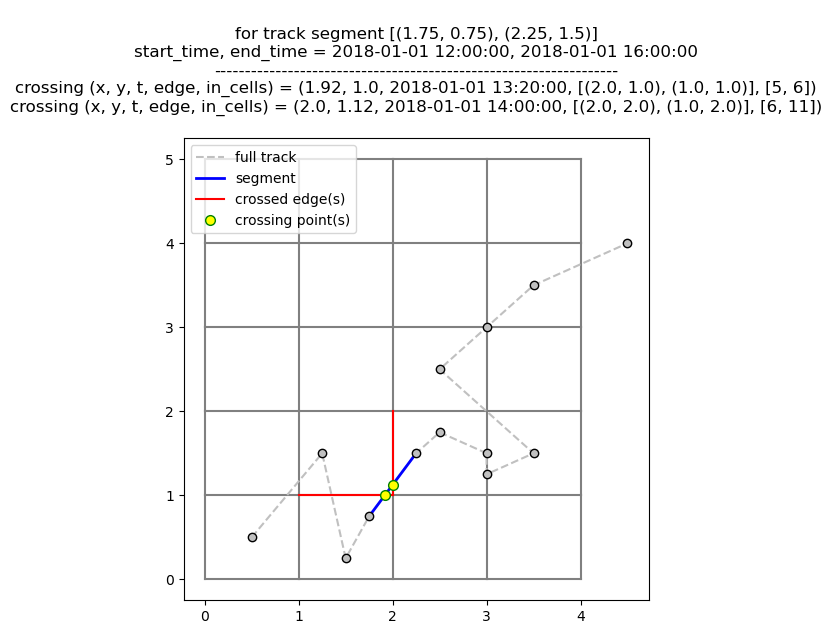

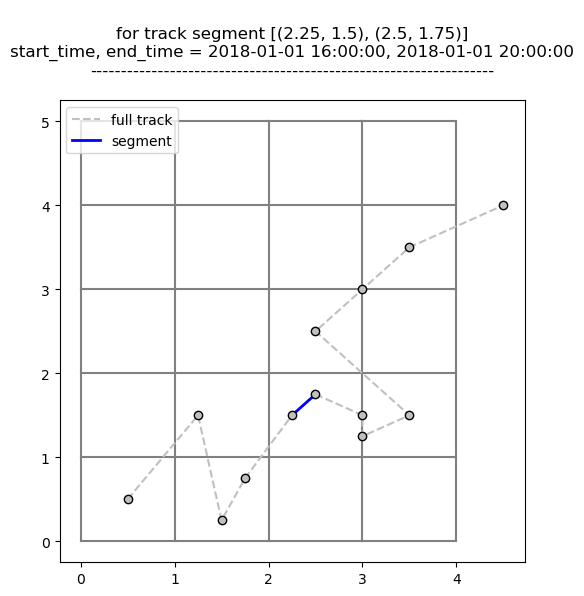

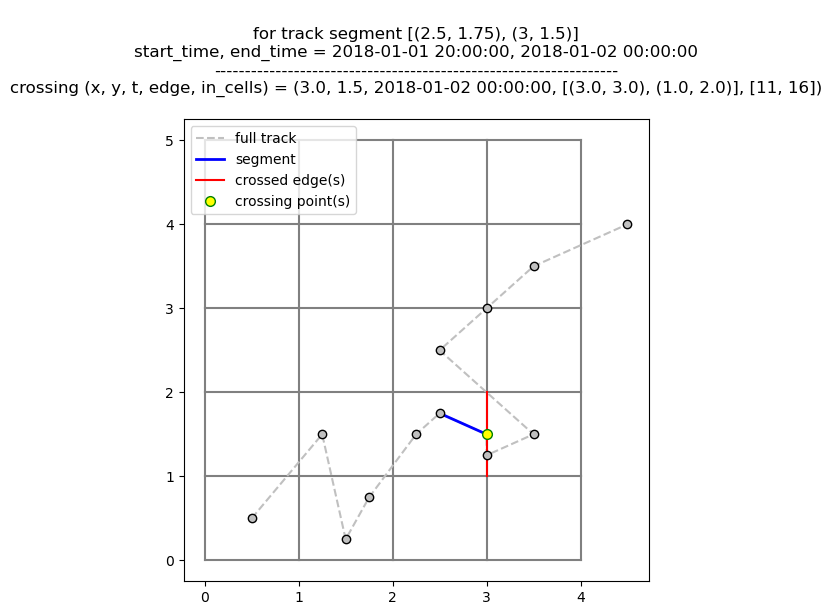

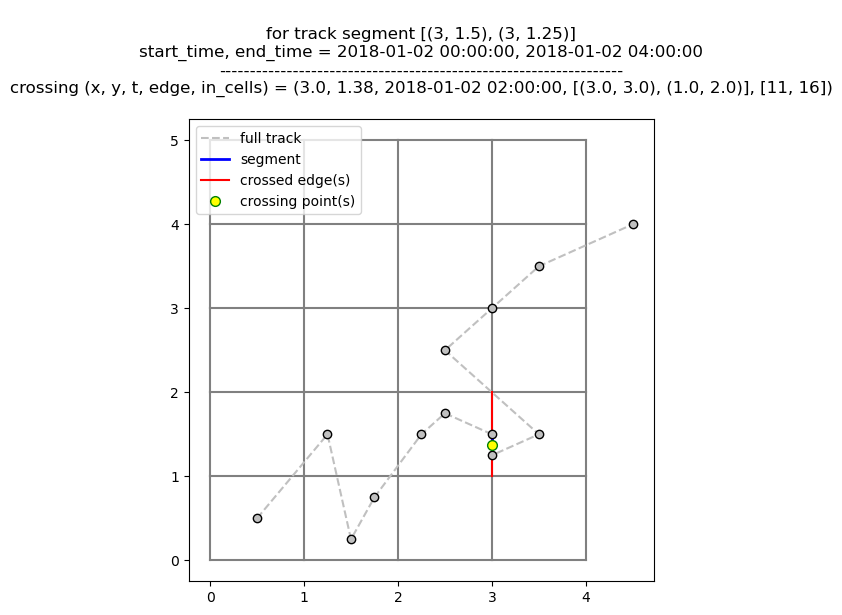

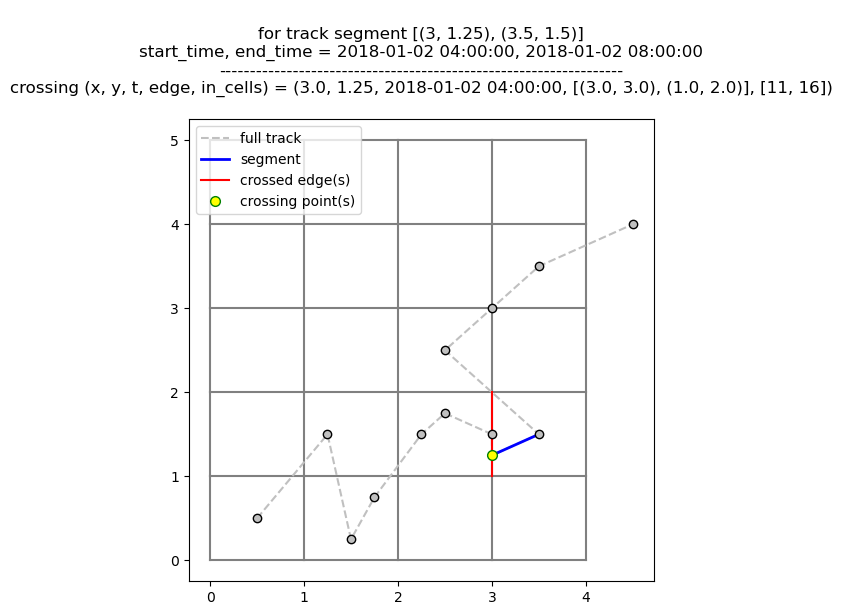

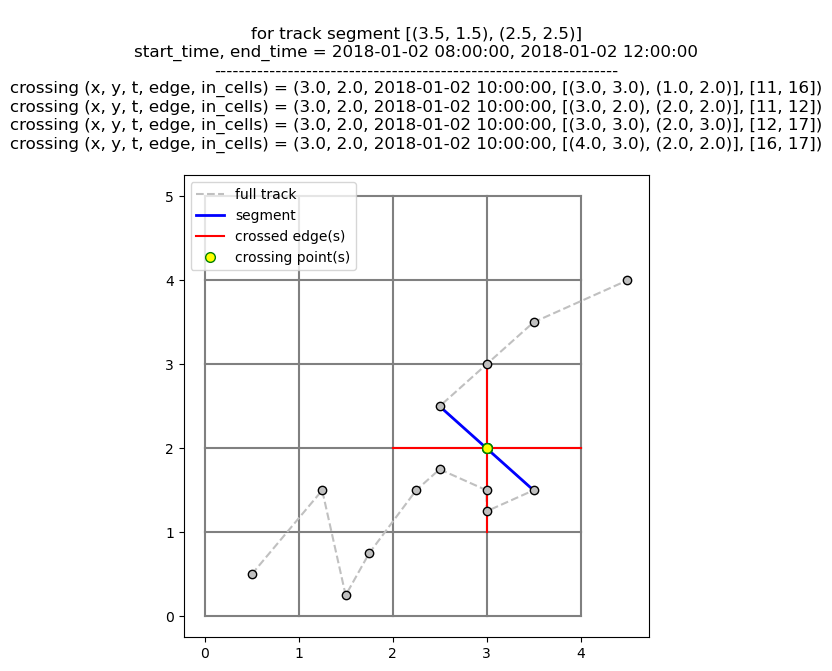

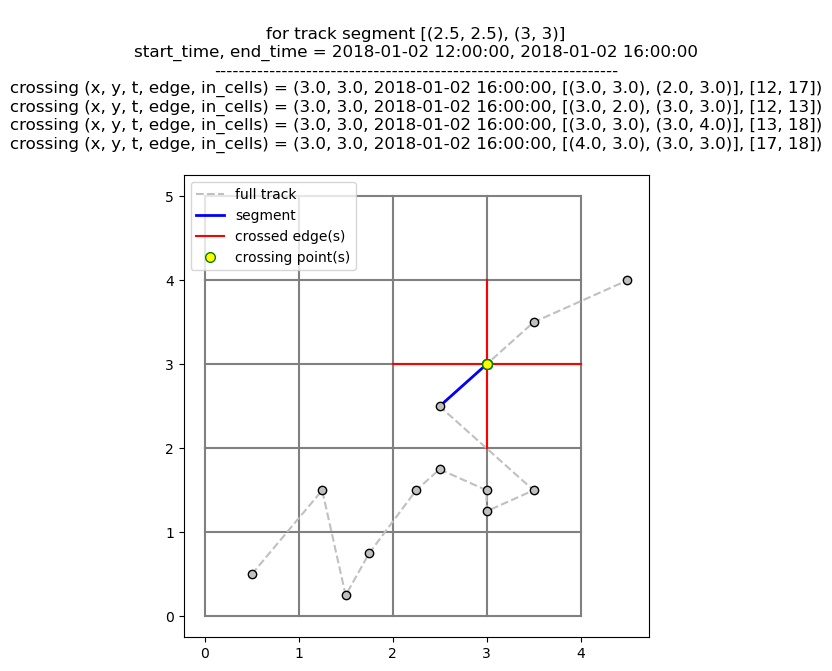

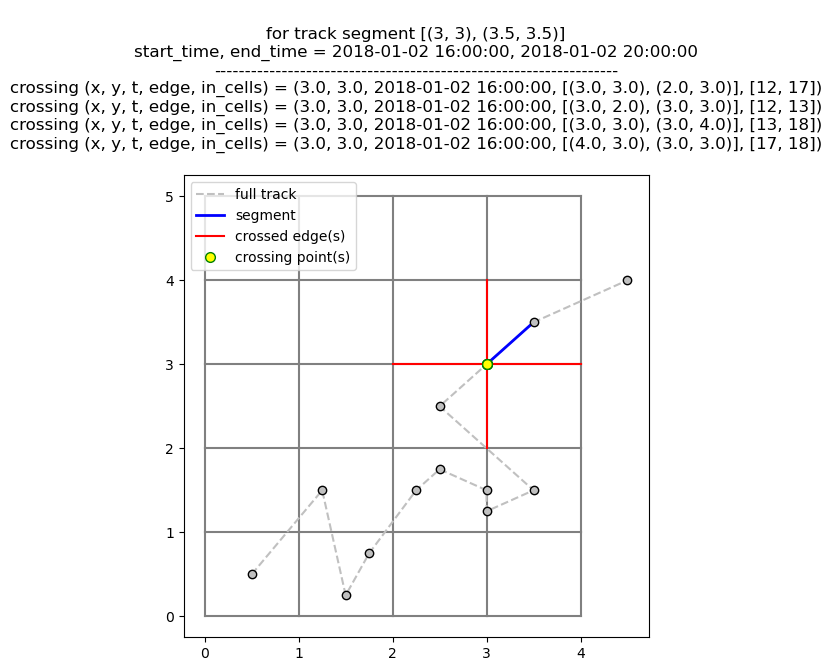

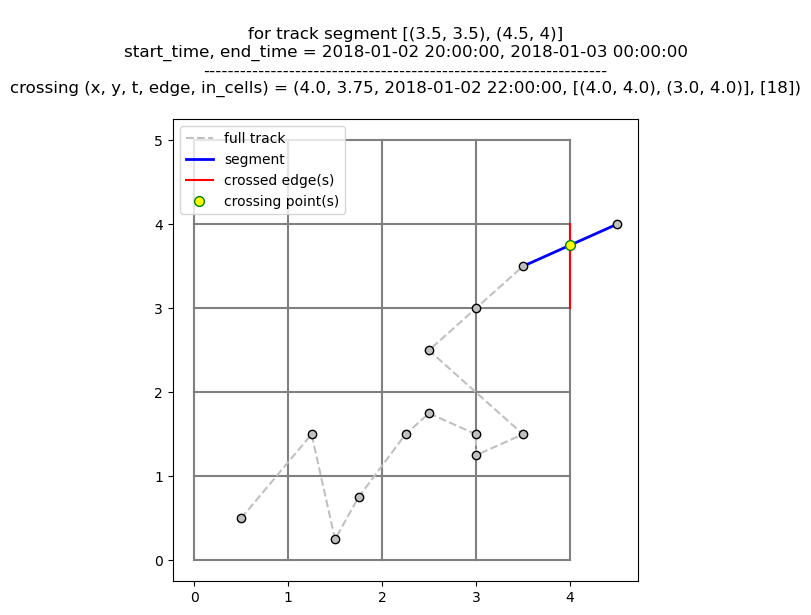

In [7]:
#####################################################################################
# find the intersection points and add them to a figure
#####################################################################################
tpts = [(0.5, 0.5), (1.25, 1.5), (1.5, 0.25), (1.75, 0.75), (2.25, 1.5), (2.5, 1.75),  
        (3, 1.5), (3, 1.25), (3.5, 1.5), (2.5, 2.5), (3, 3), (3.5, 3.5), (4.5, 4)]
sample_times = pd.date_range("2018-01-01", "2018-01-03", periods=len(tpts)) 

x = [p[0] for p in tpts]
y = [p[1] for p in tpts]
t = [st for st in sample_times]
coord_pairs = list(zip(x, y, t))

cell_list = create_cell_list(num_horz=4, num_vert=5, show_plot=False)
cell_defs = build_cell_definition(cell_list)

#crossing_points = find_crossings_per_cell(x, y, t, cell_list, cell_defs)
cpdf = find_crossings_per_cell(x, y, t, cell_list, cell_defs)
#xc, yc, tc, edges_list, incells_list, searchstrs = find_crossings_per_cell(x, y, t, cell_list, cell_defs)

### checking the output from the above function, which should be the location, time and crossed boundary for each crossing point

In [5]:
#crossing_points
cpdf

xc        yc                  tc                     edges   incells                                  searchstrs
0   0.875000  1.000000 2018-01-01 02:00:00  [(1.0, 0.0), (1.0, 1.0)]    [0, 1]               0.875_1.0_2018-01-01_02:00:00
1   1.000000  1.166667 2018-01-01 02:40:00  [(1.0, 1.0), (1.0, 2.0)]    [1, 6]  1.0_1.1666666666666667_2018-01-01_02:40:00
2   1.350000  1.000000 2018-01-01 05:36:00  [(2.0, 1.0), (1.0, 1.0)]    [5, 6]                1.35_1.0_2018-01-01_05:36:00
3   1.916667  1.000000 2018-01-01 13:20:00  [(2.0, 1.0), (1.0, 1.0)]    [5, 6]  1.9166666666666667_1.0_2018-01-01_13:20:00
4   2.000000  1.125000 2018-01-01 14:00:00  [(2.0, 2.0), (1.0, 2.0)]   [6, 11]               2.0_1.125_2018-01-01_14:00:00
5   3.000000  1.500000 2018-01-02 00:00:00  [(3.0, 3.0), (1.0, 2.0)]  [11, 16]                 3.0_1.5_2018-01-02_00:00:00
6   3.000000  1.375000 2018-01-02 02:00:00  [(3.0, 3.0), (1.0, 2.0)]  [11, 16]               3.0_1.375_2018-01-02_02:00:00
7   3.000000  1.250000 2018-01-02 04:00:00  [(3.0, 3.0), (1.0, 2.0)]  [11, 16]                3.0_1.25_2018-01-02_04:00:00
8   3.000000  2.000000 2018-01-02 10:00:00  [(3.0, 3.0), (1.0, 2.0)]  [11, 16]                 3.0_2.0_2018-01-02_10:00:00
9   3.000000  2.000000 2018-01-02 10:00:00  [(3.0, 2.0), (2.0, 2.0)]  [11, 12]                 3.0_2.0_2018-01-02_10:00:00
10  3.000000  2.000000 2018-01-02 10:00:00  [(3.0, 3.0), (2.0, 3.0)]  [12, 17]                 3.0_2.0_2018-01-02_10:00:00
11  3.000000  2.000000 2018-01-02 10:00:00  [(4.0, 3.0), (2.0, 2.0)]  [16, 17]                 3.0_2.0_2018-01-02_10:00:00
12  3.000000  3.000000 2018-01-02 16:00:00  [(3.0, 3.0), (2.0, 3.0)]  [12, 17]                 3.0_3.0_2018-01-02_16:00:00
13  3.000000  3.000000 2018-01-02 16:00:00  [(3.0, 2.0), (3.0, 3.0)]  [12, 13]                 3.0_3.0_2018-01-02_16:00:00
14  3.000000  3.000000 2018-01-02 16:00:00  [(3.0, 3.0), (3.0, 4.0)]  [13, 18]                 3.0_3.0_2018-01-02_16:00:00
15  3.000000  3.000000 2018-01-02 16:00:00  [(4.0, 3.0), (3.0, 3.0)]  [17, 18]                 3.0_3.0_2018-01-02_16:00:00
16  3.000000  3.000000 2018-01-02 16:00:00  [(3.0, 3.0), (2.0, 3.0)]  [12, 17]                 3.0_3.0_2018-01-02_16:00:00
17  3.000000  3.000000 2018-01-02 16:00:00  [(3.0, 2.0), (3.0, 3.0)]  [12, 13]                 3.0_3.0_2018-01-02_16:00:00
18  3.000000  3.000000 2018-01-02 16:00:00  [(3.0, 3.0), (3.0, 4.0)]  [13, 18]                 3.0_3.0_2018-01-02_16:00:00
19  3.000000  3.000000 2018-01-02 16:00:00  [(4.0, 3.0), (3.0, 3.0)]  [17, 18]                 3.0_3.0_2018-01-02_16:00:00
20  4.000000  3.750000 2018-01-02 22:00:00  [(4.0, 4.0), (3.0, 4.0)]      [18]                4.0_3.75_2018-01-02_22:00:00

In [6]:

cpdf['num_crossing_pts'] = np.zeros(len(cpdf))
#cpdf['tc'] = [pd.to_datetime(dat) for dat in cpdf['tc'].values]
#cpdf['edges'] = [[e] for e in cpdf.edges]
#cpdf['incells'] = [[ic] for ic in cpdf.incells]
#print(cpdf)

# maybe this check can be done faster using pd.duplicated instead?
for uniq_ss in np.unique(cpdf.searchstrs.values):
    #print('\n\n', uniq_ss, '\n---------------------------------')
    udf = cpdf.loc[cpdf.searchstrs == uniq_ss]
    #print('udf\n', udf)
    
    if len(udf) > 1:
        print('\n\n', uniq_ss, '\n---------------------------------')
        print('udf\n', udf)
        uind = cpdf.loc[cpdf.searchstrs == uniq_ss].index
        print(np.unique(udf.xc.values))
        print(np.unique(udf.yc.values))
        print(pd.to_datetime(np.unique(udf.tc.values)))
        print([e for e in udf.edges])
        print([ic for ic in udf.incells])
        print([len(udf)])
        new_row = pd.DataFrame({
            'xc': np.unique(udf.xc.values), 
            'yc': np.unique(udf.yc.values), 
            'tc': np.unique(udf.tc.values), 
            'edges': [e[0] for e in udf.edges], 
            'incells': [ic[0] for ic in udf.incells], 
            'num_crossing_pts': [len(udf)]
        }, index=[uind[0]])
        #print('\n', uind, '\n', new_row)
        
        ## drop the old rows, then add the new one instead
        #cpdf.drop(uind, inplace=True)
        #sind = [uind[0]-1 if uind[0] !=0 else uind[0]]        
        #cpdf = pd.concat([cpdf.iloc[:sind], pd.DataFrame(new_row, index=[uind[0]]), cpdf.iloc[sind:]]).reset_index(drop=True)
        ##cpdf = cpdf.sort_index().reset_index(drop=True)
    else:
        cpdf['num_crossing_pts'] = 1
        print(udf['tc'])
        #print('udf\n---------------------------------\n', udf)

#print('\n\n\n\n')
#cpdf

0   2018-01-01 02:00:00
Name: tc, dtype: datetime64[ns]
1   2018-01-01 02:40:00
Name: tc, dtype: datetime64[ns]
2   2018-01-01 05:36:00
Name: tc, dtype: datetime64[ns]
3   2018-01-01 13:20:00
Name: tc, dtype: datetime64[ns]
4   2018-01-01 14:00:00
Name: tc, dtype: datetime64[ns]
7   2018-01-02 04:00:00
Name: tc, dtype: datetime64[ns]
6   2018-01-02 02:00:00
Name: tc, dtype: datetime64[ns]
5   2018-01-02
Name: tc, dtype: datetime64[ns]


 3.0_2.0_2018-01-02_10:00:00 
---------------------------------
udf
      xc   yc                  tc                     edges   incells                   searchstrs  num_crossing_pts
8   3.0  2.0 2018-01-02 10:00:00  [(3.0, 3.0), (1.0, 2.0)]  [11, 16]  3.0_2.0_2018-01-02_10:00:00                 1
9   3.0  2.0 2018-01-02 10:00:00  [(3.0, 2.0), (2.0, 2.0)]  [11, 12]  3.0_2.0_2018-01-02_10:00:00                 1
10  3.0  2.0 2018-01-02 10:00:00  [(3.0, 3.0), (2.0, 3.0)]  [12, 17]  3.0_2.0_2018-01-02_10:00:00                 1
11  3.0  2.0 2018-01-02 10

ValueError: Length of values (4) does not match length of index (1)

In [16]:
df = pd.DataFrame({"onset": [20, 10, 40, 90, 18], "length": [1.2, 1.2, 1.2, 1.2, 1.2]})
line = pd.DataFrame({"onset": 30.0, "length": 1.3}, index=[3])
df2 = pd.concat([df.iloc[:2], line, df.iloc[2:]]).reset_index(drop=True)
print(df, '\n\n', df2)

   onset  length
0     20     1.2
1     10     1.2
2     40     1.2
3     90     1.2
4     18     1.2 

    onset  length
0   20.0     1.2
1   10.0     1.2
2   30.0     1.3
3   40.0     1.2
4   90.0     1.2
5   18.0     1.2




Each row in the following dataframe represents a boundary crossing point
(i.e., one of the orange points on the plot):

       xc    yc                   tc                     edges  in_cells
0   0.88  1.00  2018-01-01 02:00:00  [(1.0, 0.0), (1.0, 1.0)]    [0, 1]
1   1.00  1.17  2018-01-01 02:40:00  [(1.0, 1.0), (1.0, 2.0)]    [1, 6]
2   1.35  1.00  2018-01-01 05:36:00  [(2.0, 1.0), (1.0, 1.0)]    [5, 6]
3   1.92  1.00  2018-01-01 13:20:00  [(2.0, 1.0), (1.0, 1.0)]    [5, 6]
4   2.00  1.12  2018-01-01 14:00:00  [(2.0, 2.0), (1.0, 2.0)]   [6, 11]
5   3.00  1.50  2018-01-02 00:00:00  [(3.0, 3.0), (1.0, 2.0)]  [11, 16]
6   3.00  1.38  2018-01-02 02:00:00  [(3.0, 3.0), (1.0, 2.0)]  [11, 16]
7   3.00  1.25  2018-01-02 04:00:00  [(3.0, 3.0), (1.0, 2.0)]  [11, 16]
8   3.00  2.00  2018-01-02 10:00:00  [(3.0, 3.0), (1.0, 2.0)]  [11, 16]
9   3.00  2.00  2018-01-02 10:00:00  [(3.0, 2.0), (2.0, 2.0)]  [11, 12]
10  3.00  2.00  2018-01-02 10:00:00  [(3.0, 3.0), (2.0, 3.0)]  [12, 17]
11  3.00  2.0

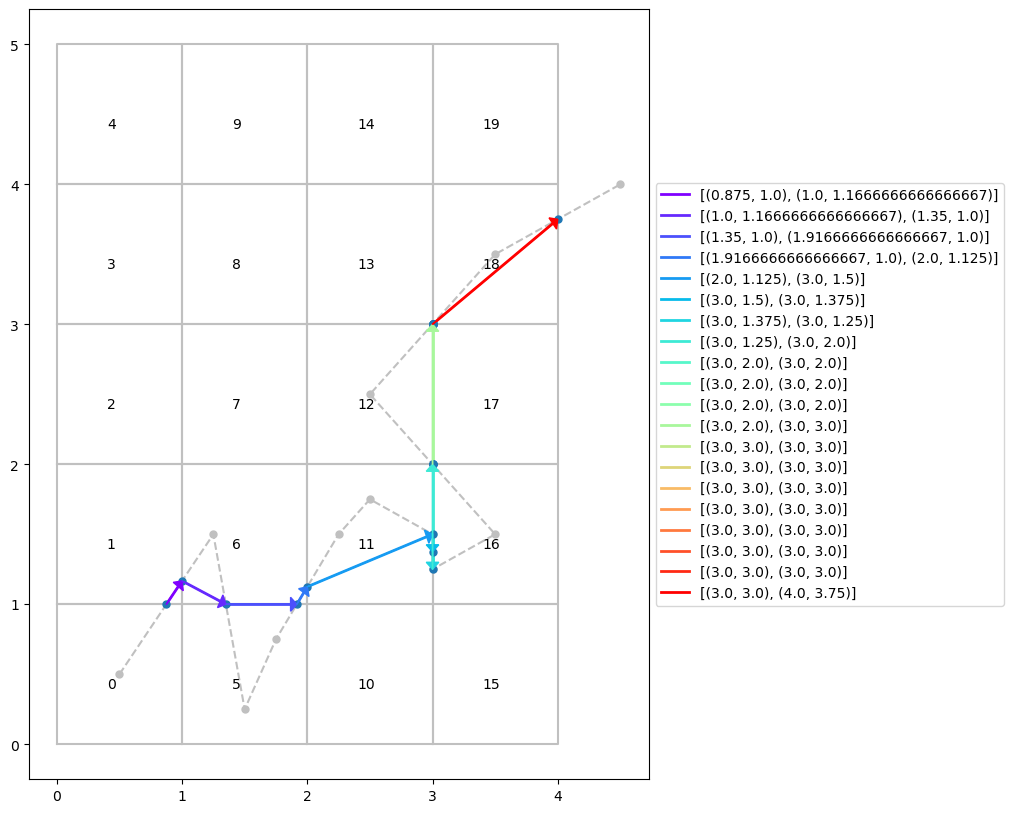

In [4]:
cpt = pd.DataFrame({'xc': ["{:.2f}".format(x) for x in xc], 
                    'yc': ["{:.2f}".format(y) for y in yc], 
                    'tc': [t.strftime('%Y-%m-%d %X') for t in tc], 
                    'edges': edges_list, 'in_cells': incells_list})



print('\n\nEach row in the following dataframe represents a boundary crossing point\n(i.e., one of the orange points on the plot):\n\n', cpt, '\n\n')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)


for pind, poly in enumerate(polylist):
    px = [p[0] for p in poly]
    py = [p[1] for p in poly]
    ax.plot(px, py, '-', color='silver')
    plt.annotate(str(pind), (np.mean(px), np.mean(py)))

ax.plot(x, y, '--', color='silver')
ax.plot(x, y, 'o', color='silver', markersize=5)

# gist_ncar, rainbox, gnuplot
colorslist = gen_color('rainbow', len(xc)-1, reverse=False)
for ind in range(0, len(xc) - 1):
    xs = [xc[ind], xc[ind+1]]
    ys = [yc[ind], yc[ind+1]]
    plt.plot(xs, ys, colorslist[ind], linewidth=2, label=(str(list(zip(xs, ys)))))
    plt.arrow(xs[0], ys[0], xs[1]-xs[0], ys[1]-ys[0], fc=colorslist[ind], ec=colorslist[ind], zorder=100, 
              head_width=0.1, head_length=0.05, length_includes_head=True)  # label=(str(list(zip(xs, ys)))))
#ax.plot(xc, yc)
ax.plot(xc, yc, 'o', markersize=5)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend()
plt.show()

### start looking at the velocity in each crossing segment

In [5]:
print('\n\n')
for i in range(0, len(xc)-1):
    segment = [(xc[i], yc[i]), (xc[i+1], yc[i+1])]
    times = [tc[i].strftime('%Y-%m-%d %X'), tc[i+1].strftime('%Y-%m-%d %X')]
    in_cell = list(set(incells_list[i]) & set(incells_list[i+1]))
    segLS = LineString(segment)  
    seg_dist = math.dist(list(segment[0]), list(segment[1]))
    tdiff = (tc[i+1] - tc[i]).total_seconds()  # /60/60
    tmid = tc[i] + (tc[i+1] - tc[i])/2
    
    print('segment = ', segment)
    print('in_cell = ', in_cell)
    print('times = ', times)
    print('tdiff = ', tdiff)
    print('tmid = ', tmid.strftime('%Y-%m-%d %X'))
    print('seg_dist = ', seg_dist)

    eff_vel = seg_dist/tdiff
    print('eff_vel = ', eff_vel)
    print('')




segment =  [(0.875, 1.0), (1.0, 1.1666666666666667)]
in_cell =  [1]
times =  ['2018-01-01 02:00:00', '2018-01-01 02:40:00']
tdiff =  2400.0
tmid =  2018-01-01 02:20:00
seg_dist =  0.2083333333333334
eff_vel =  8.680555555555559e-05

segment =  [(1.0, 1.1666666666666667), (1.35, 1.0)]
in_cell =  [6]
times =  ['2018-01-01 02:40:00', '2018-01-01 05:36:00']
tdiff =  10560.0
tmid =  2018-01-01 04:08:00
seg_dist =  0.38765677832043366
eff_vel =  3.670992218943501e-05

segment =  [(1.35, 1.0), (1.9166666666666667, 1.0)]
in_cell =  [5, 6]
times =  ['2018-01-01 05:36:00', '2018-01-01 13:20:00']
tdiff =  27840.0
tmid =  2018-01-01 09:28:00
seg_dist =  0.5666666666666667
eff_vel =  2.0354406130268198e-05

segment =  [(1.9166666666666667, 1.0), (2.0, 1.125)]
in_cell =  [6]
times =  ['2018-01-01 13:20:00', '2018-01-01 14:00:00']
tdiff =  2400.0
tmid =  2018-01-01 13:40:00
seg_dist =  0.15023130314433283
eff_vel =  6.259637631013868e-05

segment =  [(2.0, 1.125), (3.0, 1.5)]
in_cell =  [11]
times

ZeroDivisionError: float division by zero

In [28]:
people = [
{'name': "Tom", 'age': 10},
{'name': "Mark", 'age': 5},
{'name': "Pam", 'age': 7}
]

list(filter(lambda person: person['name'] == 'Pam', people))

[{'name': 'Pam', 'age': 7}]

# Sample code I might need later:

### bearing and magnitude functions from the drift-tool

In [170]:
def magnitude(x, y):
    """Calculate the magnitude of a vector"""
    return np.sqrt(x**2 + y**2)


def calculate_bearing(east, north):
    """Calculate the bearing of a vector"""
    radians = np.arctan2(east, north)
    degrees = radians * 180. / np.pi
    degrees[degrees < 0] = degrees[degrees < 0] + 360
    return degrees


# from https://gitlab.com/dfo-drift-projection/drift-workflow-tool/-/blob/main/src/plotutils/drift_correction_factor/dcf_create_stats_table.py?ref_type=heads

### getting equally spaced times to accompany the sample locations

In [43]:
tpts = [(0.5, 0.5), (1.25, 1.5), (1.5, 0.25), (1.75, 0.75), (2.25, 1.5), (2.5, 1.75)]
x = [p[0] for p in tpts]
y = [p[1] for p in tpts]
test_times = pd.date_range("2018-01-01", "2018-01-02", periods=len(tpts))  # freq='H' instead of periods returns hourly data 
t = [tt for tt in test_times]
pairs = zip(x, y, t)
#for p in pairs:
#    print(p)

### calculating time deltas

In [42]:
# the time difference
delta = datetime.strptime("11:46:38", "%H:%M:%S") - datetime.strptime("2:13:57", "%H:%M:%S")
# time difference in seconds
print(f"Time difference is {delta.total_seconds()} seconds")
# time difference in milliseconds
ms = delta.total_seconds() * 1000
print(f"Time difference is {ms} milliseconds")

Time difference is 34361.0 seconds
Time difference is 34361000.0 milliseconds


### the distance between two points

In [2]:
import math 
P = (3, 7)
Q = (-5, -9)
eDistance = math.dist(list(P), list(Q)) 
print(eDistance) 


17.88854381999832


# Examples of similar methods for reference:

In [45]:
# A potentially useful example from:
# https://gis.stackexchange.com/questions/339409/find-the-vertices-of-the-edge-of-the-polygon-where-line-intersects-using-shapely

from shapely.wkt import loads
lin = loads('LineString (289.63171806167395061 -200.22555066079294761, 380.69030837004402201 -65.28898678414094547)')
pol = loads('Polygon ((112.23259911894263041 -229.94933920704846742, 178.75726872246687549 -113.4132158590308137, 309.44757709251092592 -114.35682819383258391, 376.44405286343607031 -230.42114537444933831, 305.67312775330390195 -344.59823788546259493, 176.39823788546246419 -345.07004405286346582, 112.23259911894263041 -229.94933920704846742))')

# the LinearRing
from shapely.geometry import LineString
polin = LineString(list(pol.exterior.coords))

# intersection 
pt = polin.intersection(lin)
print(pt.wkt)

# iterate through the edges to determine if Shapely point is within
points = list(polin.coords)
for i,j in zip(points, points[1:]):
   if LineString((i,j)).distance(pt) < 1e-8:
       print(i,j)

## from: https://gis.stackexchange.com/questions/427726/incorrect-plotting-of-point-and-line
#fig, ax = plt.subplots()
#plt.plot(*lin.xy)
#plt.plot(*pol.exterior.xy)
#ax.axis('equal')

POINT (327.02683172946365 -144.81102988883518)
(309.4475770925109, -114.35682819383258) (376.44405286343607, -230.42114537444934)


In [72]:
# Another potentially useful example, but likely not needed:
# https://stackoverflow.com/questions/70925976/get-coordinate-of-points-where-a-line-crosses-a-polygon 
# I'm getting the error that "TypeError: 'MultiPoint' object is not iterable". It seems like that error is covered here: 
# https://stackoverflow.com/questions/76074394/typeerror-multipolygon-object-is-not-iterable

#import alphashape
#from shapely.geometry import LineString
#import matplotlib.pyplot as plt
#import numpy as np

##replicating your example
#fig, ax = plt.subplots()

#line_xy = [[350, 100],[0, 120]]
#points = np.asarray([(17, 158),(15, 135),(38, 183),(43, 19),(93, 88),(96, 140),(149, 163),(128, 248),(216, 265),(248, 210),
#                     (223, 167),(256, 151),(331, 214),(340, 187),(316, 53),(298, 35),(182, 0),(121, 42)])

#alpha = 0.99 * alphashape.optimizealpha(points)

#hull = alphashape.alphashape(points, alpha)
#hull_pts = hull.exterior.coords.xy

#p = LineString(line_xy)

#ax.plot(*hull_pts, c="green")
#ax.scatter(points[:,0], points[:,1], marker="o", color="red")
#ax.scatter(*hull_pts, marker="s", color="red")

#ax.plot(*p.coords.xy, color='blue')

##retrieving intersection 
#inters = hull.intersection(p)

##checking for object type to retrieve all intersection coordinates
#if inters.type == "LineString":
#    coords = np.asarray([inters.coords.xy])
#elif inters.type == "MultiLineString":
#    coords = np.asarray([l.coords.xy for l in inters.geoms])
    
##reshaping array point coordinates into a form that does not make my head hurt
#coords = coords.transpose(1, 0, 2).reshape(2, -1)
#print(coords)

#plt.show()

[2]


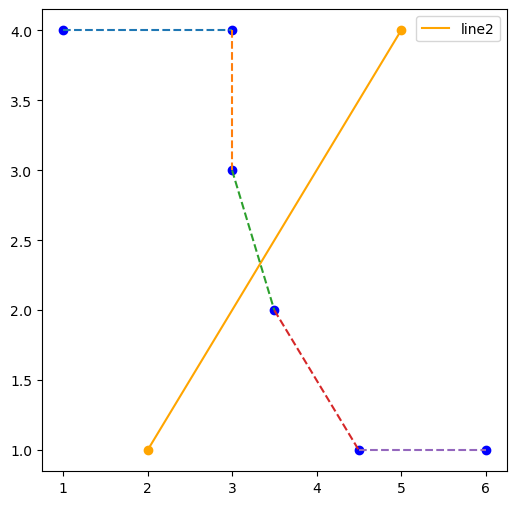

In [225]:
# https://stackoverflow.com/questions/27192694/calculate-the-intersection-point-of-a-line-to-a-linestring-and-define-the-linest
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

line1_string=LineString([(1,4),(3,4),(3,3),(3.5,2),(4.5,1),(6,1)])
line2_string=LineString([(5,4),(2,1)])

# Convert input line into list of line segments
Line1_segs = [LineString(p) for p in pairwise(Line1_string.coords[:])]

# Find the intersections
intersect_segs = [i for i, s in enumerate(Line1_segs) if line2_string.intersects(s)]
print(intersect_segs)  # [2]

# plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
#ax.plot(*line1_string.xy, '-', color='blue', label='line1')
ax.plot(*line1_string.xy, 'o', color='blue', label='_no_label_')
ax.plot(*line2_string.xy, color='orange', label='line2')
ax.plot(*line2_string.xy, 'o', color='orange', label='_no_label_')
for ls in Line1_segs:
    ax.plot(*ls.xy, '--')
plt.legend()
plt.show()